# ViT Segmentation

Como foi explicado no primeiro notebook sobre ViT, os Transformers são modelos que podem ser entendidos como *Encoders*. Isso significa que podemos utilizar o ViT apenas para a extração de *features* do nosso problema e, em seguida, adicionar uma *head* para realizar a tarefa principal, que pode ser classificação, segmentação ou alguma abordagem *multi-modal*. Dessa forma, neste notebook, iremos explorar como usar um ViT pré-treinado, construir uma *head* de segmentação e aplicá-lo à tarefa de segmentação do *Rock Dataset*.


# Preâmbulo

Imports, funções, downloads e instalação do Pytorch.

In [1]:
# Downloading the Digital Rock Physics Benchmarks dataset.
!git clone https://github.com/fkrzikalla/drp-benchmarks

# Removing unnecessary files.
# !rm -r drp-benchmarks/images/fontainebleau
# !rm -r drp-benchmarks/images/spherepack

!rm drp-benchmarks/images/*/segmented-kongju.mat
!rm drp-benchmarks/images/*/segmented-stanford.raw.gz
!rm drp-benchmarks/images/*/segmented-vsg.raw.gz

# Uncompressing raw segmentations.
!gunzip drp-benchmarks/images/berea/segmented-kongju.raw.gz
!gunzip drp-benchmarks/images/grosmont/segmented-kongju.raw.gz

Cloning into 'drp-benchmarks'...
remote: Enumerating objects: 2106, done.
remote: Total 2106 (delta 0), reused 0 (delta 0), pack-reused 2106 (from 1) 31.81 MiB/sReceiving objects:   0% (13/2106), 65.81 MiB | 32.44 MiB/sReceiving objects:   0% (14/2106), 100.75 MiB | 33.03 MiB/sReceiving objects:   0% (15/2106), 134.62 MiB | 33.06 MiB/sReceiving objects:   1% (22/2106), 152.10 MiB | 33.23 MiB/sReceiving objects:   1% (24/2106), 152.10 MiB | 33.23 MiB/sReceiving objects:   1% (42/2106), 187.47 MiB | 33.86 MiB/sReceiving objects:   2% (43/2106), 187.47 MiB | 33.86 MiB/sReceiving objects:   2% (61/2106), 222.48 MiB | 34.13 MiB/sReceiving objects:   3% (64/2106), 240.27 MiB | 34.03 MiB/sReceiving objects:   3% (78/2106), 257.81 MiB | 34.22 MiB/sReceiving objects:   4% (85/2106), 275.42 MiB | 34.31 MiB/sReceiving objects:   4% (97/2106), 293.19 MiB | 34.56 MiB/sReceiving objects:   5% (106/2106), 310.67 MiB | 34.47 MiB/sReceiving objects:   5% (115/2106), 328.46 MiB | 34.58 MiB/sReceiving ob

## Imports

In [2]:
# Bibliotecas principais
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split

# Transformações e manipulação de dados
import torchvision
from torchvision import transforms, models, datasets

# Utilitários de visualização e manipulação de dados
import gc
import os
import glob
import time
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

from skimage import io, transform
from sklearn import metrics
from tqdm.notebook import tqdm
from torch.utils.data import Dataset, DataLoader
from transformers import ViTModel

# Divisão de dados
from sklearn.model_selection import train_test_split



In [3]:
# Setting predefined arguments.
args = {
    'epoch_num': 10,                    # Number of epochs.
    'dataset': 'grosmont',              # Dataset. (grosmont or bereau)
    'n_classes': 2,                     # Number of classes in segmentation task.
    'lr': 1e-4,                         # Learning rate.
    'weight_decay': 5e-4,               # L2 penalty.
    'momentum': 0.9,                    # Momentum.
    'num_workers': 2,                   # Number of workers on data loader.
    'batch_size': 32,                    # Mini-batch size.
    'crop_size': 256,                   # Random crop size.
    'show_freq': 1,                     # Frequency for showing predictions.
    'root': 'drp-benchmarks/images'     # root directory for the images
}

if torch.cuda.is_available():
    args['device'] = torch.device('cuda')
else:
    args['device'] = torch.device('cpu')

print(args['device'])

cuda


## Funções Auxiliares

Funções para avaliação de métricas, apresentação de imagens e das predições

In [4]:
def evaluate(preds, labels):
    f1_list = []
    iou_list = []

    for i in tqdm(range(len(preds)), desc='Metrics'):
        f1 = metrics.f1_score(labels[i].flatten(), preds[i].flatten())
        iou = metrics.jaccard_score(labels[i].flatten(), preds[i].flatten())

        f1_list.append(f1)
        iou_list.append(iou)

    f1_list = np.asarray(f1_list)
    iou_list = np.asarray(iou_list)

    return f1_list, iou_list

def show_image(img, mask):
    img = img.cpu().numpy().transpose(1, 2, 0)  # (C, H, W) -> (H, W, C)
    img = np.clip(img, 0, 1) 
    
    if mask.ndim == 3:
        mask = mask.squeeze(0)  # (1, H, W) -> (H, W)
    
    fig, axes = plt.subplots(1, 2, figsize=(12, 6))

    axes[0].imshow(img)
    axes[0].axis('off') 
    axes[0].set_title("Imagem")

    axes[1].imshow(mask, cmap='gray')
    axes[1].axis('off')  
    axes[1].set_title("Máscara")

    plt.show()

def show_image_and_mask_prediction(img, mask, pred):
    img = img.cpu().numpy().transpose(1, 2, 0)  # (C, H, W) -> (H, W, C)
    img = np.clip(img, 0, 1)  

    if mask.ndim == 3:  
        mask = mask.squeeze(0)  # (1, H, W) -> (H, W)
        
    pred = torch.argmax(pred, dim=0).cpu().numpy() 
    
    if pred.ndim == 3: 
        pred = pred.squeeze(0)  # (1, H, W) -> (H, W)

    fig, axes = plt.subplots(1, 3, figsize=(18, 6))

    axes[0].imshow(img)
    axes[0].axis('off')  
    axes[0].set_title("Imagem")

    axes[1].imshow(mask, cmap='gray')
    axes[1].axis('off')  
    axes[1].set_title("Máscara")

    axes[2].imshow(pred, cmap='gray')
    axes[2].axis('off')  
    axes[2].set_title("Previsão")

    plt.show()

## Dataset - RockDataset

## Carregamento do Dataset `Rockdataset`

Aqui será feito o carregamento do dataset `Rockdataset`, que já foi utilizado em uma tarefa anterior de segmentação com uma rede convolucional U-Net, na semana de CNN. 

O carregamento de dados será diferente desta vez, pois utilizaremos uma versão pré-pronta e pré-treinada do Vision Transformer para essa tarefa. Essa abordagem exige que a imagem e a máscara estejam em um formato específico:

- Imagem: `(batch_size, 3 , altura, largura)` → 3 canais (RGB), 224x224
- Máscara: `(batch_size, 1, altura, largura)` → 1 canal (grayscal, 224x224

In [5]:
class RockDataset(Dataset):
    def __init__(self, root, mode, dataset, crop_size=256, num_classes=2, transform=None):

        # Initializing variables.
        self.root = root
        self.mode = mode
        self.dataset = dataset
        self.crop_size = crop_size
        self.num_classes = num_classes
        self.transform = transform

        # Creating list of image files.
        self.imgs = self.make_dataset()

        # Check for consistency in list.
        if len(self.imgs) == 0:

            raise (RuntimeError('Found 0 images, please check the data set.'))

 
    def make_dataset(self):

        # Joining input paths.
        self.img_path = os.path.join(self.root,
                                     self.dataset,
                                     'tif')
        self.msk_path = os.path.join(self.root,
                                     self.dataset,
                                     'segmented-kongju.raw')

        # Preload mask volume.
        transpose_sequence = [0, 2, 1]

        if self.mode == 'train':
            self.msk_vol = np.fromfile(open(self.msk_path, 'rb'),
                                       dtype=np.int8).reshape(1024, 1024, 1024)
            self.msk_vol = self.msk_vol.transpose(*transpose_sequence)[:-64]

        elif self.mode == 'test':
            self.msk_vol = np.fromfile(open(self.msk_path, 'rb'),
                                       dtype=np.int8).reshape(1024, 1024, 1024)
            self.msk_vol = self.msk_vol.transpose(*transpose_sequence)[-64:]

        # Reading paths from file.
        if self.mode == 'train':
            items = sorted([f for f in os.listdir(self.img_path) if os.path.isfile(os.path.join(self.img_path, f))])[:-64]
        elif self.mode == 'test':
            items = sorted([f for f in os.listdir(self.img_path) if os.path.isfile(os.path.join(self.img_path, f))])[-64:]

        # Returning list.
        return items
 
    def __len__(self):

        return len(self.imgs)

    def __getitem__(self, idx):
        # Reading items from list.
        f = self.imgs[idx]

        img_path = os.path.join(self.img_path, f)

        # Reading images.
        img = io.imread(img_path)
        mask = self.msk_vol[idx]
    
        # Fazendo o casting apropriado
        img = img.astype(np.float32)
        mask = mask.astype(np.int64)
    
        # Z-Score Normalization
        img = (img - img.mean()) / img.std()
    
        # Se for treino: crop aleatório
        if self.mode == 'train':
            randh, randw = np.random.randint(0, 1024 - self.crop_size, size=2)
            img = img[randh:randh+self.crop_size, randw:randw+self.crop_size]
            mask = mask[randh:randh+self.crop_size, randw:randw+self.crop_size]
            
            img = np.stack([img, img, img], axis=0)  # (3, 256, 256)
            mask = np.expand_dims(mask, axis=0)  # (1, 256, 256)
        
        else:  # Validação: dividir em 16 partes e retornar cada uma separadamente
            patches = [
                (img[i:i+256, j:j+256], mask[i:i+256, j:j+256])
                for i in range(0, 1024, 256) for j in range(0, 1024, 256)
            ]
        
            img, mask = patches[idx % 16]  # Cada chamada retorna um patch individual
            
            img = np.stack([img, img, img], axis=0)  # (3, 256, 256)
            mask = np.expand_dims(mask, axis=0)  # (1, 256, 256)
    
        # Convertendo para tensor
        img = torch.tensor(img, dtype=torch.float32)
        mask = torch.tensor(mask, dtype=torch.int64)
    
        if self.transform:
            img = self.transform(img)    # (3, 224, 224)
            mask = self.transform(mask)  # (1, 224, 224)
    
        return img, mask

### Datasets e Dataloaders
#### 1) Crie os Dataloaders


In [6]:
# Define a transformação com Compose
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Redimensiona para o tamanho desejado
])

gc.collect()
# Instantiating dataloaders.
root = args['root']

# 1) train_set =
# 2) valid_set =


print('Número de instâncias de treino:', len(train_set))
print('Número de instâncias de validação:', len(test_set))


# 1) train_dataloader = -> batch_size=32, shuffle=True, num_workers=4
# 2) valid_dataloader = -> batch_size=32, shuffle=False, num_workers=4


# Verificando tamanhos e dados esperados
for imgs, masks in train_loader:
    print(imgs.shape)  # Esperado: torch.Size([32, 3, 224, 224])
    print(masks.shape)  # Esperado: torch.Size([32, 1, 224, 224])
    print(imgs.dtype, masks.dtype) # Esperado: torch.float32 torch.int64
    break
# Exemplo de iteração para validação
for imgs, masks in test_loader:
    print(imgs.shape)  # Esperado: torch.Size([32, 3, 224, 224])
    print(masks.shape)  # Esperado: torch.Size([32, 1, 224, 224])
    print(imgs.dtype, masks.dtype) # Esperado: torch.float32 torch.int64
    break

Número de instâncias de treino: 960
Número de instâncias de validação: 64
torch.Size([32, 3, 224, 224])
torch.Size([32, 1, 224, 224])
torch.float32 torch.int64
torch.Size([32, 3, 224, 224])
torch.Size([32, 1, 224, 224])
torch.float32 torch.int64


### Exemplo de Dados

Exibindo imagens do batch:


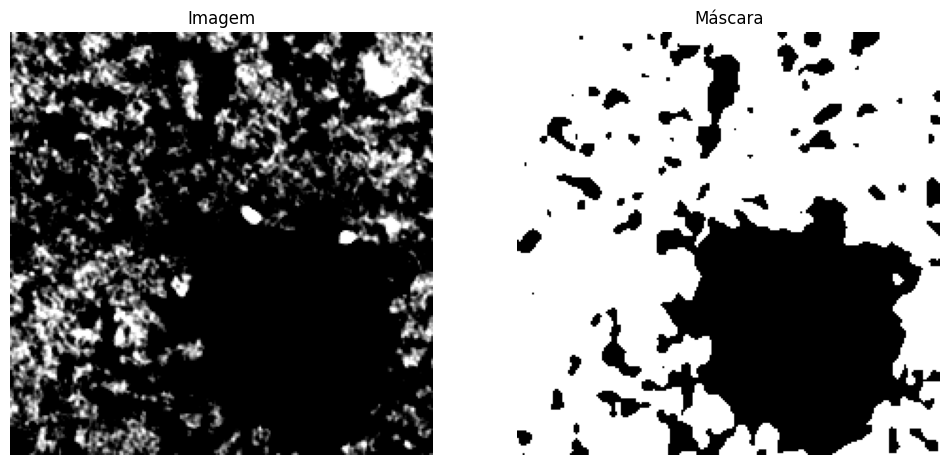

In [7]:
for imgs, masks in train_loader:
    print("Exibindo imagens do batch:")
    
    for i in range(1):
        show_image(imgs[i], masks[i])  # Mostrando a imagem i do batch
    break  

## Definindo o Modelo - ViT Segmentation

Aqui iremos definir a classe do nosso modelo `ViTSegmentation`. Para isso, utilizaremos um ViT pré-treinado (`vit_model`) como *encoder* e, em seguida, aplicaremos um *decoder* (`head`), que consistirá em uma camada `Conv2D` simples para realizar a segmentação. Após essa etapa, faremos um *upsample* para que a saída do modelo tenha o mesmo tamanho da máscara (`mask`).

#### 2) Defina ViTSegmentation

In [8]:
class ViTSegmentation(nn.Module):
    def __init__(self, vit_model, num_classes):
        super(ViTSegmentation, self).__init__()

        # 1) Defina self.vit
        # 2) Defina self.decoder -> 768 é a dimensão do embedding do ViT
        # 3) defina self.upsample -> fator 16x

    def forward(self, x):

        # 1) Passe o input pelo ViT
        # 2) Pegue o último estado com .last_hidden_state -> Formato: (batch_size, num_patches + 1, 768)
        # 3) Tire o CLS (não iremos classificar, mas ele vem de padrão no modelo pré-trinado)
        # 4) Defina algo para patches.shape
        # 5) Defina patch_size = sqrt(num_patches)
        # 6) Redimensionar para (batch_size, embedding_dim, patch_size, patch_size)
        # 7) Passe pelo Decoder
        # 8) Faça o Upsample

        return outputs

#### Carregando o modelo pré-treinado
> É normal que dê algum Warning de peso não inicializado

In [13]:
# Carregar ViT pré-treinado
vit_model = ViTModel.from_pretrained("google/vit-base-patch16-224")
model = ViTSegmentation(vit_model, num_classes=2)


Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


### Testando plots e tamanhos passados no modelo

Batch de imagens: torch.Size([32, 3, 224, 224])
Batch de máscaras: torch.Size([32, 1, 224, 224])
Saída do modelo: torch.Size([32, 2, 224, 224])


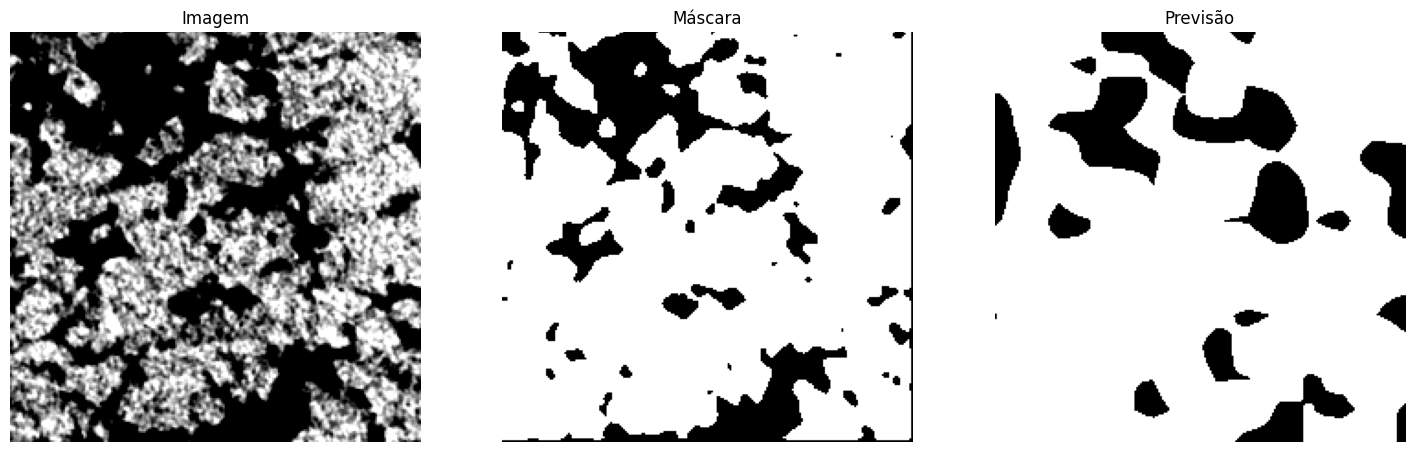

In [17]:
for images, masks in test_loader:
    print(f"Batch de imagens: {images.shape}")
    print(f"Batch de máscaras: {masks.shape}")
    outputs = model(images)
    print(f"Saída do modelo: {outputs.shape}")

    show_image_and_mask_prediction(images[31], masks[31], outputs[31])
    break

## Treinamento e Avaliação (Exemplo básico)

#### 3) Escolha o otimizador e loss mais adequados

In [18]:
weight_decay = 5e-4
learning_rate = 1e-4

# Escolha o otimizador e loss mais adequads
# 1) optimizer =
# 2) criterion =


#### 4) Faça o loop de treino

In [24]:
def train(model, train_dataloader, criterion, optimizer, device):
    tic = time.time()
    
    model.to(device)
    model.train()
    train_losses = []
    all_labels, all_preds = [], []
    
    for i, batch in (pbar := tqdm(enumerate(train_dataloader), total=len(train_dataloader), unit='batch')):
        inputs, labels = batch
        inputs, labels = inputs.to(device), labels.to(device)
        labels = labels.squeeze(1).long()

        # Faça o loop de treino padrão
        # .
        # .
        # .

        preds = outputs.argmax(dim=1)
        all_preds.append(preds.cpu().numpy())
        all_labels.append(labels.cpu().numpy())
        
        train_losses.append(loss.item())
        pbar.set_description(f"Train loss: {np.mean(train_losses):.4f}")
    
    f1, iou = evaluate(all_preds, all_labels)
    tac = time.time()
    
    print('[train], [loss %.4f +/- %.4f], [iou %.4f +/- %.4f], [f1 %.4f +/- %.4f], [time %.2f]' % (
        np.mean(train_losses), np.std(train_losses), iou.mean(), iou.std(), f1.mean(), f1.std(), (tac - tic)))

def validate(model, test_dataloader, criterion, epoch, device):
    tic = time.time()
    display_images_freq = 2
    
    model.to(device)
    model.eval()
    valid_losses = []
    all_labels, all_preds = [], []
    
    with torch.no_grad():
        for i, batch in (pbar := tqdm(enumerate(test_dataloader), total=len(test_dataloader), unit='batch')):
            inputs, labels = batch
            inputs, labels = inputs.to(device), labels.to(device)
            labels = labels.squeeze(1).long()
            
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            
            preds = outputs.argmax(dim=1)
            all_preds.append(preds.cpu().numpy())
            all_labels.append(labels.cpu().numpy())
            
            valid_losses.append(loss.item())
            pbar.set_description(f"Valid loss: {np.mean(valid_losses):.4f}")
            
            if i == 0 and epoch % display_images_freq == 0:
                fig, ax = plt.subplots(2, 3, figsize=(10, 7))
                perm = np.random.permutation(inputs.size(0))
                
                for p in range(2):
                    ax[p, 0].imshow(inputs[perm[p], 0].cpu().numpy())
                    ax[p, 0].set_title('Image')
                    ax[p, 1].imshow(labels[perm[p]].cpu().numpy())
                    ax[p, 1].set_title('Label')
                    ax[p, 2].imshow(preds[perm[p]].cpu().numpy())
                    ax[p, 2].set_title('Prediction')
                    
                    for j in range(3):
                        ax[p, j].set_xticks([])
                        ax[p, j].set_yticks([])
                
                plt.show()
    
    f1, iou = evaluate(all_preds, all_labels)
    tac = time.time()
    
    print('[test], [loss %.4f +/- %.4f], [iou %.4f +/- %.4f], [f1 %.4f +/- %.4f], [time %.2f]' % (
        np.mean(valid_losses), np.std(valid_losses), iou.mean(), iou.std(), f1.mean(), f1.std(), (tac - tic)))


 ========== Epoch 1 ========== 


  0%|          | 0/30 [00:00<?, ?batch/s]

Metrics:   0%|          | 0/30 [00:00<?, ?it/s]

[train], [loss 0.2843 +/- 0.0169], [iou 0.8600 +/- 0.0116], [f1 0.9247 +/- 0.0068], [time 26.87]


  0%|          | 0/2 [00:00<?, ?batch/s]

Metrics:   0%|          | 0/2 [00:00<?, ?it/s]

[test], [loss 0.3150 +/- 0.0021], [iou 0.8501 +/- 0.0024], [f1 0.9190 +/- 0.0014], [time 2.11]
 ========== Epoch 2 ========== 


  0%|          | 0/30 [00:00<?, ?batch/s]

Metrics:   0%|          | 0/30 [00:00<?, ?it/s]

[train], [loss 0.2742 +/- 0.0149], [iou 0.8651 +/- 0.0101], [f1 0.9276 +/- 0.0058], [time 27.30]


  0%|          | 0/2 [00:00<?, ?batch/s]

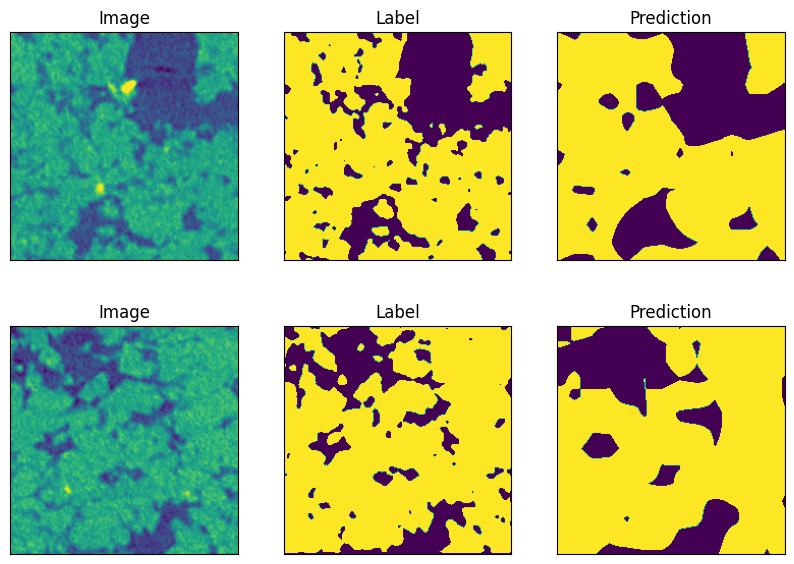

Metrics:   0%|          | 0/2 [00:00<?, ?it/s]

[test], [loss 0.3153 +/- 0.0001], [iou 0.8410 +/- 0.0017], [f1 0.9136 +/- 0.0010], [time 2.30]
 ========== Epoch 3 ========== 


  0%|          | 0/30 [00:00<?, ?batch/s]

Metrics:   0%|          | 0/30 [00:00<?, ?it/s]

[train], [loss 0.2708 +/- 0.0145], [iou 0.8668 +/- 0.0098], [f1 0.9286 +/- 0.0056], [time 27.33]


  0%|          | 0/2 [00:00<?, ?batch/s]

Metrics:   0%|          | 0/2 [00:00<?, ?it/s]

[test], [loss 0.3039 +/- 0.0006], [iou 0.8518 +/- 0.0024], [f1 0.9200 +/- 0.0014], [time 2.05]
 ========== Epoch 4 ========== 


  0%|          | 0/30 [00:00<?, ?batch/s]

Metrics:   0%|          | 0/30 [00:00<?, ?it/s]

[train], [loss 0.2680 +/- 0.0138], [iou 0.8682 +/- 0.0090], [f1 0.9294 +/- 0.0051], [time 27.25]


  0%|          | 0/2 [00:00<?, ?batch/s]

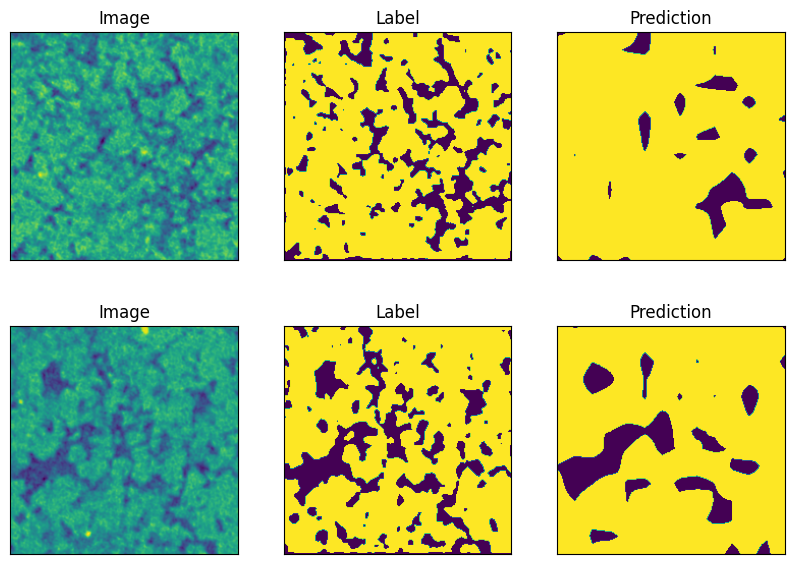

Metrics:   0%|          | 0/2 [00:00<?, ?it/s]

[test], [loss 0.3085 +/- 0.0014], [iou 0.8528 +/- 0.0025], [f1 0.9206 +/- 0.0014], [time 2.37]
 ========== Epoch 5 ========== 


  0%|          | 0/30 [00:00<?, ?batch/s]

Metrics:   0%|          | 0/30 [00:00<?, ?it/s]

[train], [loss 0.2684 +/- 0.0145], [iou 0.8676 +/- 0.0093], [f1 0.9291 +/- 0.0053], [time 26.86]


  0%|          | 0/2 [00:00<?, ?batch/s]

Metrics:   0%|          | 0/2 [00:00<?, ?it/s]

[test], [loss 0.3013 +/- 0.0011], [iou 0.8534 +/- 0.0029], [f1 0.9209 +/- 0.0017], [time 2.11]
 ========== Epoch 6 ========== 


  0%|          | 0/30 [00:00<?, ?batch/s]

Metrics:   0%|          | 0/30 [00:00<?, ?it/s]

[train], [loss 0.2615 +/- 0.0136], [iou 0.8713 +/- 0.0086], [f1 0.9312 +/- 0.0049], [time 27.25]


  0%|          | 0/2 [00:00<?, ?batch/s]

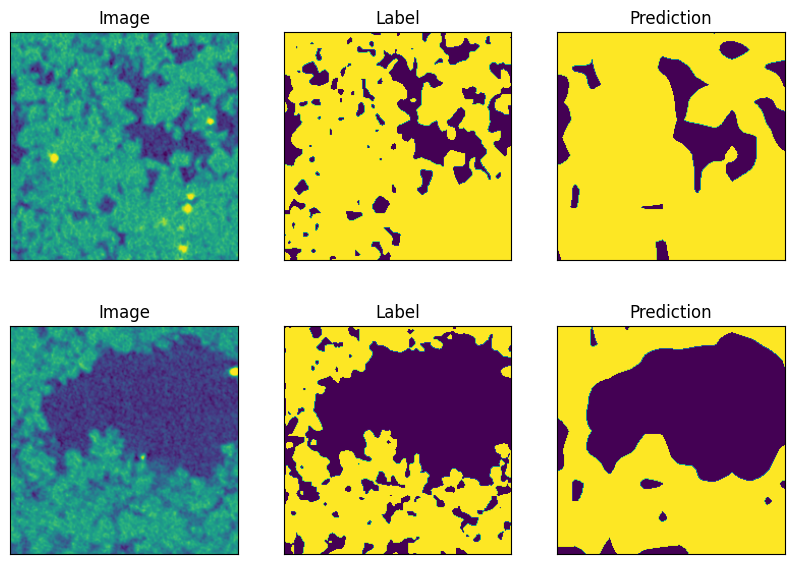

Metrics:   0%|          | 0/2 [00:00<?, ?it/s]

[test], [loss 0.3007 +/- 0.0006], [iou 0.8538 +/- 0.0026], [f1 0.9211 +/- 0.0015], [time 2.38]
 ========== Epoch 7 ========== 


  0%|          | 0/30 [00:00<?, ?batch/s]

Metrics:   0%|          | 0/30 [00:00<?, ?it/s]

[train], [loss 0.2661 +/- 0.0124], [iou 0.8676 +/- 0.0099], [f1 0.9291 +/- 0.0057], [time 27.33]


  0%|          | 0/2 [00:00<?, ?batch/s]

Metrics:   0%|          | 0/2 [00:00<?, ?it/s]

[test], [loss 0.3027 +/- 0.0002], [iou 0.8498 +/- 0.0024], [f1 0.9188 +/- 0.0014], [time 2.11]
 ========== Epoch 8 ========== 


  0%|          | 0/30 [00:00<?, ?batch/s]

Metrics:   0%|          | 0/30 [00:00<?, ?it/s]

[train], [loss 0.2686 +/- 0.0110], [iou 0.8662 +/- 0.0082], [f1 0.9283 +/- 0.0047], [time 27.33]


  0%|          | 0/2 [00:00<?, ?batch/s]

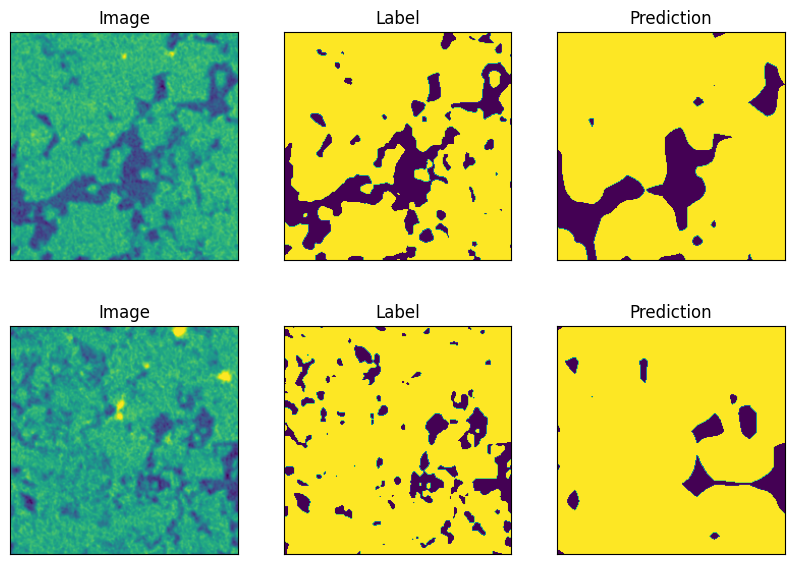

Metrics:   0%|          | 0/2 [00:00<?, ?it/s]

[test], [loss 0.3023 +/- 0.0017], [iou 0.8541 +/- 0.0023], [f1 0.9213 +/- 0.0013], [time 2.34]
 ========== Epoch 9 ========== 


  0%|          | 0/30 [00:00<?, ?batch/s]

Metrics:   0%|          | 0/30 [00:00<?, ?it/s]

[train], [loss 0.2784 +/- 0.0145], [iou 0.8640 +/- 0.0094], [f1 0.9270 +/- 0.0054], [time 27.57]


  0%|          | 0/2 [00:00<?, ?batch/s]

Metrics:   0%|          | 0/2 [00:00<?, ?it/s]

[test], [loss 0.3095 +/- 0.0014], [iou 0.8527 +/- 0.0027], [f1 0.9205 +/- 0.0016], [time 2.10]
 ========== Epoch 10 ========== 


  0%|          | 0/30 [00:00<?, ?batch/s]

Metrics:   0%|          | 0/30 [00:00<?, ?it/s]

[train], [loss 0.2715 +/- 0.0154], [iou 0.8649 +/- 0.0103], [f1 0.9275 +/- 0.0059], [time 27.68]


  0%|          | 0/2 [00:00<?, ?batch/s]

In [ ]:
num_epochs = 10
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


for epoch in range(1, num_epochs + 1):
    print(f' ========== Epoch {epoch} ========== ')

    train(model, train_loader, criterion, optimizer, device)
    validate(model, test_loader, criterion, epoch, device)

## Conclusões

Assim como no primeiro notebook sobre ViT, essa mesma questão persiste: esse tipo de arquitetura precisa de muitos dados e tempo de treinamento para obter um bom desempenho nas tarefas que lhe forem atribuídas.

Dessa forma, o modelo levará muito mais tempo para convergir. Mesmo utilizando um modelo pré-treinado, ele foi ajustado para problemas de classificação, o que dificulta a adaptação para uma nova tarefa. Além disso, nossa cabeça de segmentação é extremamente simples, consistindo apenas em uma única convolução. Um cabeçote mais elaborado poderia melhorar os resultados das previsões.

Ainda assim, conseguimos métricas razoáveis e previsões coerentes, embora inferiores às obtidas com a UNet padrão, que alcançou bons resultados de forma muito mais rápida.

## **Desafio**
> Faça uma Classe que seja uma cabeça de Segmentação, treine o modelo por mais épocas e veja se os resultados melhoram.